In [1]:
library(RcppCNPy)
library(EnvStats)

options(warn=-1)


Attaching package: ‘EnvStats’

The following objects are masked from ‘package:stats’:

    predict, predict.lm

The following object is masked from ‘package:base’:

    print.default



In [5]:


encodeAromaticSeq <- function(sequence) {
  
  
  aromatic <- c('F','W','Y')
  numberstring_split <- strsplit(sequence, "")[[1]]
  l=c()
  for (residue in numberstring_split){
    if (residue %in% aromatic){
      elem=1}
    else{
      elem=0
    }
    l<-c(l,elem)
    }
    
  return(array(l))
  }


In [6]:
t_col <- function(color, percent = 50, name = NULL) {
  #      color = color name
  #    percent = % transparency
  #       name = an optional name for the color

## Get RGB values for named color
rgb.val <- col2rgb(color)

## Make new color using input color as base and alpha set by transparency
t.col <- rgb(rgb.val[1], rgb.val[2], rgb.val[3],
             max = 255,
             alpha = (100 - percent) * 255 / 100,
             names = name)

## Save the color
invisible(t.col)
}
## END

In [112]:

find_IDR_block <- function(original_sequence,windowsize,name,plot="no") {
    
    
    
    original_sequence=gsub("[\n]", "", original_sequence)

    
    encoded_seq=encodeAromaticSeq(original_sequence)

  
  l=c()
  indexes=c()
  for (residue in seq(1, length(encoded_seq)-windowsize+1, by=1)){
    sequence=(encoded_seq[residue:(residue+windowsize-1)])
    
    ##find observed interarrivals:
    interarrivals=diff(which(sequence==1))

    if (length(interarrivals) == 0) {
      interarrivals=windowsize
    }
      

    #rate parameter (mean occurrence of aromatic residues)
    lambda=sum(sequence== 1)/length(sequence)
    
    
    #KS test to check if the inter-arrival times follow a geometrical distribution
    p_val=ks.test(interarrivals,"pgeom",prob=lambda)$p.value
    
    l<-c(l,p_val)

  }
  
    
  l[is.na(l)] = 1
    
  #name_plot=paste("./plots_pdf_quasiIDRFinder/",name,"deneme.pdf", sep = "")
  #pdf(file = name_plot, useDingbats = FALSE, width=6, height=5)  
    
  
  num=which.min(l) 
  
  
  new_sequence=(encoded_seq[num:(num+windowsize-1)])
    
  new_sequence2=substr(original_sequence,num,(num+windowsize-1))


  #define the threshold  
    
  thre=mean(l)/2  

    
  thre_cut=which(as.vector(l) < thre)
    
  #print(thre_cut)  
    
    
  if (length(thre_cut)==0){
      print("minima could not extended by 3 points- no detected periodicity")
      break
  }
  

  #split consequative values
  a=split(thre_cut, cumsum(c(1, diff(thre_cut) != 1))) 
    

  for (residue in a){
    if ((num  %in%  residue) & (length(residue)>=2)){
        array_selected=residue
        start=min(array_selected)
        end=max(array_selected)+windowsize
        next
        
        
     }   
}  

  if(plot=="yes"){
      
    plot(seq(windowsize/2, (length(encoded_seq)-windowsize+windowsize/2)), l,  pch = 18, col = "blue", type = "b", lty = 2,xlim=c(1,length(encoded_seq)), ylab='p-values', xlab='Residue number',main=as.character(name))
    lines(ksmooth(seq(windowsize/2, (length(encoded_seq)-windowsize+windowsize/2)),l,'normal',bandwidth = 10),type='l',col='blue',lwd=2) 
    smooth_func= ksmooth(seq(windowsize/2, (length(encoded_seq)-windowsize+windowsize/2)),l,'normal',bandwidth = 10)
    lines(smooth_func$x[min(array_selected):max(array_selected)],smooth_func$y[min(array_selected):max(array_selected)],type='b',col='red',lwd=2)
      
  }  
    #output
    return(c(start,end,end-start+1,min(l)))
  
}


In [113]:
data= read.csv("/project/Rif1/fasta/subsetted_fasta/IDPpi/IDPpi_codes/HumanProteom_dns/canonical_sequences_unique/Dataset/HG30_pep_annotation.csv", stringsAsFactors = FALSE)


In [114]:
## Plot the p-values for protein HNRNPA1 as an example

[1] 1.49000e+02 3.73000e+02 2.25000e+02 1.10794e-04

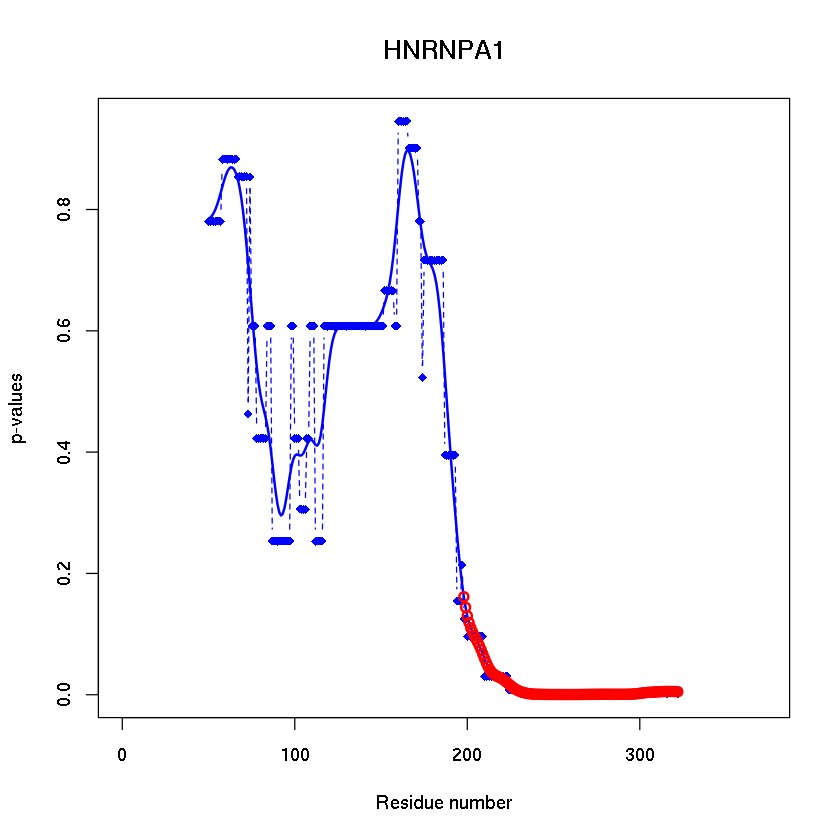

In [115]:
key="HNRNPA1"
sequence=as.character(subset(data, gene_symbol==key, select="sequence"))
find_IDR_block(sequence,100,"HNRNPA1",plot="yes")

In [118]:
predicted_quazi=substr(sequence,(find_IDR_block(sequence,100,key)[1]),(find_IDR_block(sequence,100,key)[2]))
predicted_quazi

[1] "AFVTFDDHDSVDKIVIQKYHTVNGHNCEVRKALSKQEMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGGYGGGGPGYSGGSRGYGSGGQGYGNQGSGYGGSGSYDSYNNGGGGGFGGGSGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGPYGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF"

In [119]:
encoded_seq=encodeAromaticSeq(predicted_quazi)

In [120]:
interarrivals=diff(which(encoded_seq==1))
lambda=sum(encoded_seq == 1)/length(encoded_seq)

In [121]:
p_val=ks.test(interarrivals,"pgeom",lambda)$p.value

In [122]:
#KS statistics
p_val

[1] 1.210405e-05

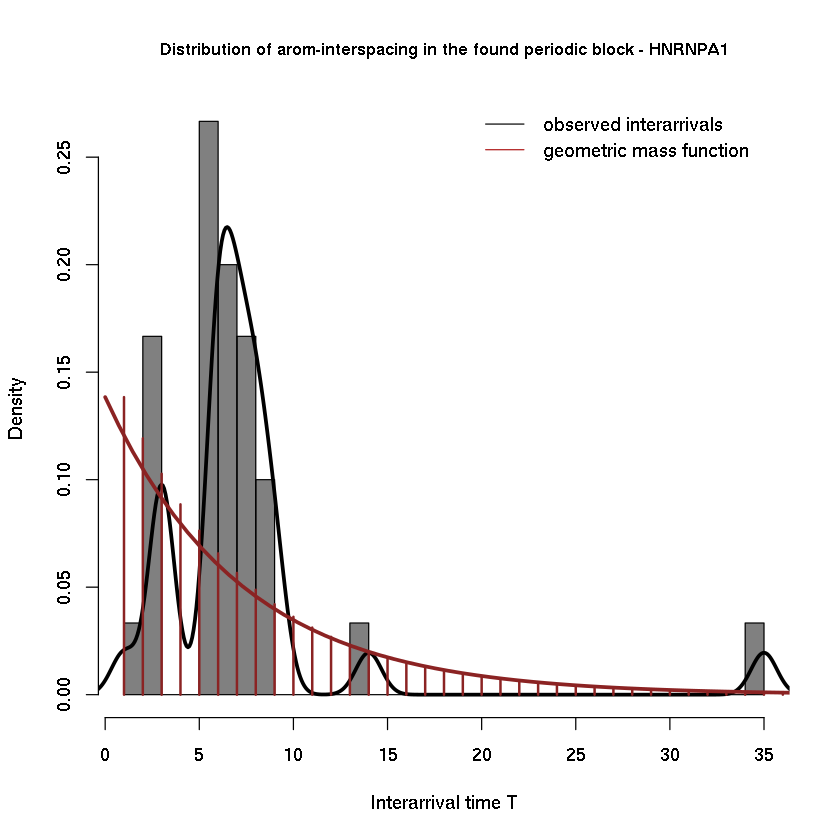

In [123]:

mycol <- t_col("black", perc = 50, name = "black")
hist(interarrivals,xlab="Interarrival time T",col = mycol,breaks=30,main=paste("Distribution of arom-interspacing in the found periodic block -", key),freq=FALSE, cex.main=0.8) # density plot
lines(density(interarrivals), # density plot
 lwd = 3, # thickness of line
 col = "black")
  
#plot geometric probability mass function on top of histogram  
x_dgeom <- seq(0, max(interarrivals), by = 1) # Specify x-values (interarrivals) for dgeom function
y_dgeom <- dgeom(x_dgeom, prob = lambda)  # Apply dgeom function to the interarrival values
lines(y_dgeom,type='h',col ="brown4", lwd = 2)   # Plot dgeom values


t <- seq(0,10/lambda,length.out=100)
points(t,lambda*exp(-lambda*t),type="l", col ="brown4",lwd=3) # plots original density function on top of histogram

legend("topright", 
         c("observed interarrivals", "geometric mass function"), 
         lty=c(1, 1), 
         col=c("black","firebrick"), 
         bty = "n", cex = 1)



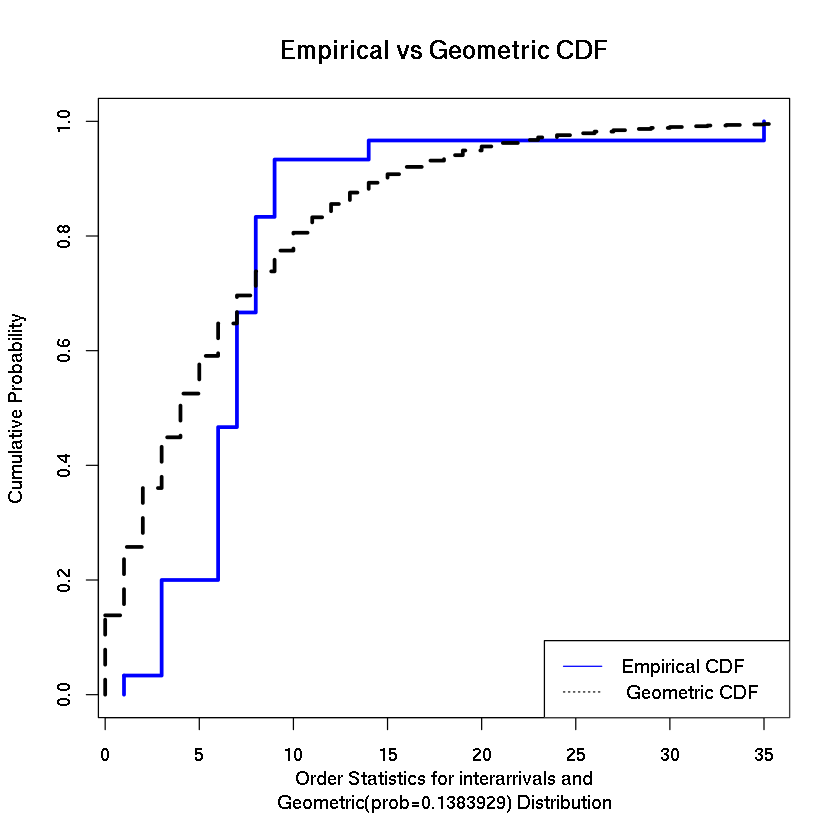

In [125]:



cdfCompare(interarrivals,dist ="geom",param.list = list(prob=lambda),discrete = TRUE,main = "Empirical vs Geometric CDF")
legend("bottomright",c("Empirical CDF"," Geometric CDF"),col=c("blue","black"),lty=c("solid","dotted"))
